In [ ]:
import random
import numpy as np
import tensorflow as tf
import os
import json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from zipfile import ZipFile

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# Kaggle API credentials setup
!pip install kaggle
kaggle_credentails = json.load(open("kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [ ]:
!kaggle datasets download -d chaitanyaravijaiswal/project-database
!unzip project-database.zip -d project-database

403 - Forbidden - Permission 'datasets.get' was denied
unzip:  cannot find or open project-database.zip, project-database.zip.zip or project-database.zip.ZIP.


In [ ]:
# Directory setup
base_dir = '/content/project-database/project-database/color'

# Enhanced Data Augmentation
img_size = 224
batch_size = 16  # Reduced batch size for faster training
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)


NameError: name 'ImageDataGenerator' is not defined

In [ ]:
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)


Found 10660 images belonging to 12 classes.
Found 2660 images belonging to 12 classes.


In [ ]:
# More Efficient Model Architecture
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 3494348 (13.33 MB)
Trainable params: 265484 (1.01 MB)
Non-trainable params: 3228864 (12.32 MB)
______________

In [ ]:
# Training with More Epochs and Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,  # Reduced number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
666/666 [==============================] - 820s 1s/step - loss: 0.0531 - accuracy: 0.9811 - val_loss: 0.0941 - val_accuracy: 0.9736
Epoch 2/20
666/666 [==============================] - 703s 1s/step - loss: 0.0448 - accuracy: 0.9860 - val_loss: 0.0876 - val_accuracy: 0.9714
Epoch 3/20
666/666 [==============================] - 705s 1s/step - loss: 0.0420 - accuracy: 0.9854 - val_loss: 0.0454 - val_accuracy: 0.9872
Epoch 4/20
666/666 [==============================] - 722s 1s/step - loss: 0.0442 - accuracy: 0.9853 - val_loss: 0.0402 - val_accuracy: 0.9846
Epoch 5/20
666/666 [==============================] - 714s 1s/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 0.0563 - val_accuracy: 0.9842
Epoch 6/20
666/666 [==============================] - 713s 1s/step - loss: 0.0354 - accuracy: 0.9892 - val_loss: 0.0580 - val_accuracy: 0.9838
Epoch 7/20
666/666 [==============================] - 693s 1s/step - loss: 0.0416 - accuracy: 0.9869 - val_loss: 0.0722 - val_accuracy: 0.9770

In [ ]:
# Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze more layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
666/666 [==============================] - 843s 1s/step - loss: 0.0896 - accuracy: 0.9708 - val_loss: 0.0386 - val_accuracy: 0.9861
Epoch 2/10
666/666 [==============================] - 824s 1s/step - loss: 0.0588 - accuracy: 0.9808 - val_loss: 0.0325 - val_accuracy: 0.9898
Epoch 3/10
666/666 [==============================] - 836s 1s/step - loss: 0.0488 - accuracy: 0.9834 - val_loss: 0.0380 - val_accuracy: 0.9883
Epoch 4/10
666/666 [==============================] - 833s 1s/step - loss: 0.0420 - accuracy: 0.9840 - val_loss: 0.0310 - val_accuracy: 0.9906
Epoch 5/10
666/666 [==============================] - 826s 1s/step - loss: 0.0439 - accuracy: 0.9854 - val_loss: 0.0228 - val_accuracy: 0.9917
Epoch 6/10
666/666 [==============================] - 851s 1s/step - loss: 0.0343 - accuracy: 0.9872 - val_loss: 0.0310 - val_accuracy: 0.9921
Epoch 7/10
666/666 [==============================] - 874s 1s/step - loss: 0.0369 - accuracy: 0.9865 - val_loss: 0.0309 - val_accuracy: 0.9906

In [ ]:
model.load_weights('best_model.h5')
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

166/166 [==============================] - 134s 805ms/step - loss: 0.0333 - accuracy: 0.9898
Validation Accuracy: 98.98%


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/plant_disease_model.h5')


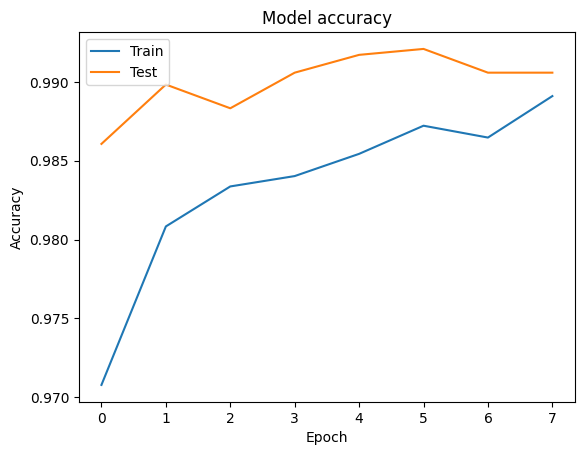

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


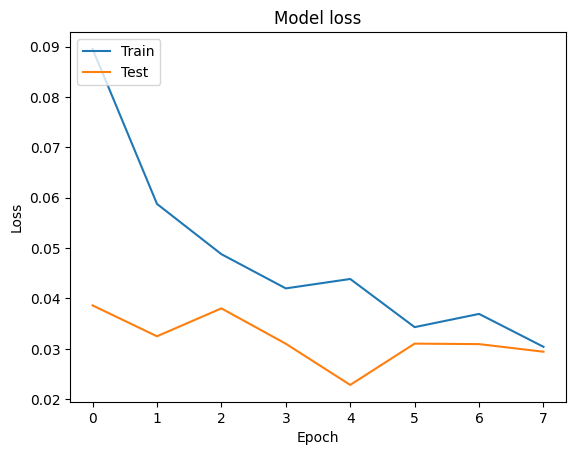

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

In [ ]:
def predict_image_class(model, image_path, class_indices, threshold=0.5):

    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class_index]

    if confidence < threshold:
        return "not detected"

    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [ ]:
class_indices = {v: k for k, v in train_generator.class_indices.items()}
json.dump(class_indices, open('class_indices.json', 'w'))

NameError: name 'train_generator' is not defined

In [ ]:
# Example Usage
image_path ='/content/Black_Leaf_Streak.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 93ms/step
Predicted Class Name: Peach___Bacterial_spot


In [ ]:
import os
import json
from PIL import Image
import numpy as np
import tensorflow as tf

# Path to the saved model on Google Drive
model_path = '/content/drive/MyDrive/Colab Notebooks/plant_disease_model.h5'

# Load the pre-trained model
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

# Paths to class indices and remedies JSON files
class_indices_path = '/content/drive/MyDrive/Colab Notebooks/class_indices.json'
remedies_path = '/content/drive/MyDrive/Colab Notebooks/remedies.json'

# Load the class names
with open(class_indices_path, 'r') as f:
    class_indices = json.load(f)

# Load the remedies
with open(remedies_path, 'r') as f:
    remedies = json.load(f)

# Function to load and preprocess the image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.0
    return img_array

# Function to predict the class of an image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[str(predicted_class_index)]
    print(predicted_class_index)
    print(predictions.shape)
    return predicted_class_name

# Example usage: Replace 'example_image.jpg' with the path to your image
image_path = '/content/CNLB 1.jpg'  # Upload your image to Colab or use a path from Google Drive
prediction = predict_image_class(model, image_path, class_indices)
print(f'Prediction: {prediction}')

Model loaded successfully!
1/1 [==============================] - 1s 1s/step
2
(1, 12)
Prediction: Corn_(maize)___Northern_Leaf_Blight


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
